In [1]:
import os
import pandas as pd
import numpy as np

folder_path = 'newdata processed/'

sequences = []
labels = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        data = pd.read_csv(file_path)
        
        # Convert specific columns to integers directly within the DataFrame

        data['Samples'] = pd.to_numeric(data['Samples'], errors='coerce').astype(int)
        data['Class_Label'] = pd.to_numeric(data['Class_Label'], errors='coerce').astype(int)

        
        # Extract features
        
        sequence = data[['Samples']]
        sequences.append(sequence.values)
        
        # Extract label 
        label = data['Class_Label']
        labels.append(label)

# Convert lists to numpy arrays
X = np.array(sequences)
y = np.array(labels)


In [2]:
# Check for unique files
files = os.listdir(folder_path)
print("Total files:", len(files))
print("Unique files:", len(set(files)))


Total files: 4428
Unique files: 4428


In [3]:
sample_file_path = os.path.join(folder_path, files[0])
sample_data = pd.read_csv(sample_file_path)
print(sample_data.head())  # See first few rows
print("Unique rows in sample file:", sample_data.drop_duplicates().shape[0])


   Sample_no  Samples  Class_Label      x_cor       y_cor  z_cor  \
0        101      351            0  650018.93  6554204.28  42.92   
1        102      347            0  650018.93  6554204.28  42.92   
2        103      362            0  650018.93  6554204.28  42.92   
3        104      397            0  650018.93  6554204.28  42.92   
4        105      426            0  650018.93  6554204.28  42.92   

   Sample_Length     Point  Returning_Point  Final_Class  
0        0.05996  10.01756              167            1  
1        0.05996  10.01756              167            1  
2        0.05996  10.01756              167            1  
3        0.05996  10.01756              167            1  
4        0.05996  10.01756              167            1  
Unique rows in sample file: 300


In [4]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}") 

Shape of X: (4428, 300, 1)
Shape of y: (4428, 300)


In [5]:
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))

Label distribution: {0: 754099, 1: 70848, 2: 450087, 3: 4658, 4: 48708}


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


y_one_hot = to_categorical(y, num_classes=5)

# Normalize the input data (X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 300)).reshape(-1, 300, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.2, random_state=42)

# Build the model
model = Sequential()

# First LSTM layer (return_sequences=True because we need sequence output for the next layer)
model.add(LSTM(128, input_shape=(300, 1), return_sequences=True))  
model.add(Dropout(0.5))  

# Second LSTM layer (also return_sequences=True to keep passing sequences)
model.add(LSTM(64, return_sequences=True))  
model.add(Dropout(0.5))

# TimeDistributed to apply the Dense layer at each time step
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Dropout(0.5))

# TimeDistributed output layer to predict one of 5 classes at each time step
model.add(TimeDistributed(Dense(5, activation='softmax')))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 300, 64)           49408     
                                                                 
 dropout_1 (Dropout)         (None, 300, 64)           0         
                                                                 
 time_distributed (TimeDistr  (None, 300, 64)          4160      
 ibuted)                                                         
                                                                 
 dropout_2 (Dropout)         (None, 300, 64)           0         
                                                        

In [8]:
print("Shape of one-hot encoded labels:", y_one_hot.shape)

Shape of one-hot encoded labels: (4428, 300, 5)


In [9]:
# Convert one-hot encoded labels back to original class labels
y_train_labels = np.argmax(y_train, axis=-1).flatten()
y_test_labels = np.argmax(y_test, axis=-1).flatten()

# Check label distribution in training set
train_label_distribution = np.bincount(y_train_labels)

# Check label distribution in testing set
test_label_distribution = np.bincount(y_test_labels)

# Display the distribution of class labels
print("Training label distribution:", train_label_distribution)
print("Testing label distribution:", test_label_distribution)


Training label distribution: [603357  56672 359863   3746  38962]
Testing label distribution: [150742  14176  90224    912   9746]


In [10]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')


Epoch 1/100
89/89 [==============================] - 76s 726ms/step - loss: 0.9234 - accuracy: 0.6656 - val_loss: 0.6699 - val_accuracy: 0.7209
Epoch 2/100
89/89 [==============================] - 62s 702ms/step - loss: 0.4608 - accuracy: 0.8611 - val_loss: 0.2878 - val_accuracy: 0.9103
Epoch 3/100
89/89 [==============================] - 63s 708ms/step - loss: 0.2752 - accuracy: 0.9148 - val_loss: 0.1789 - val_accuracy: 0.9370
Epoch 4/100
89/89 [==============================] - 62s 697ms/step - loss: 0.2182 - accuracy: 0.9259 - val_loss: 0.1734 - val_accuracy: 0.9379
Epoch 5/100
89/89 [==============================] - 60s 671ms/step - loss: 0.6599 - accuracy: 0.8516 - val_loss: 1.3161 - val_accuracy: 0.4272
Epoch 6/100
89/89 [==============================] - 60s 681ms/step - loss: 0.6948 - accuracy: 0.7517 - val_loss: 0.3447 - val_accuracy: 0.8860
Epoch 7/100
89/89 [==============================] - 30s 330ms/step - loss: 0.3544 - accuracy: 0.8923 - val_loss: 0.2840 - val_accuracy:

In [11]:
train_loss = history.history['loss']  # Training loss per epoch
train_accuracy = history.history['accuracy']  # Training accuracy per epoch


val_loss = history.history['val_loss']  # Validation loss per epoch
val_accuracy = history.history['val_accuracy']  # Validation accuracy per epoch

# Print final epoch accuracy and loss
print(f"Final training accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Final training loss: {train_loss[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracy[-1] * 100:.2f}%")
print(f"Final validation loss: {val_loss[-1]:.4f}")


Final training accuracy: 94.25%
Final training loss: 0.1455
Final validation accuracy: 94.85%
Final validation loss: 0.1249


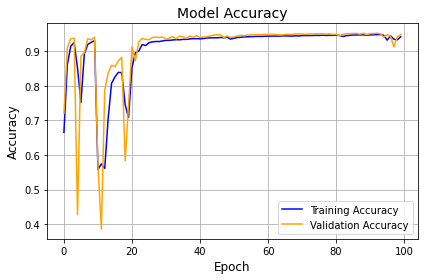

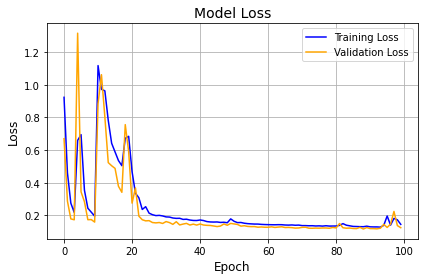

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)  
plt.tight_layout()  
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)  
plt.tight_layout()  
plt.show()


In [13]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities (one-hot) to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)

# Convert true labels from one-hot encoding to class labels
y_test_labels = np.argmax(y_test, axis=-1)

# Flatten the arrays if necessary to ensure they're 1D
y_pred_labels = y_pred_labels.flatten()
y_test_labels = y_test_labels.flatten()

# Generate a classification report
report = classification_report(y_test_labels, y_pred_labels, digits=4)

# Print the classification report
print(report)



28/28 [==============================] - 3s 82ms/step
              precision    recall  f1-score   support

           0     0.9731    0.9720    0.9725    150742
           1     0.6482    0.6268    0.6374     14176
           2     0.9548    0.9783    0.9664     90224
           3     0.0000    0.0000    0.0000       912
           4     0.9292    0.8652    0.8961      9746

    accuracy                         0.9485    265800
   macro avg     0.7011    0.6885    0.6945    265800
weighted avg     0.9446    0.9485    0.9464    265800



C:\Users\nabil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nabil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nabil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


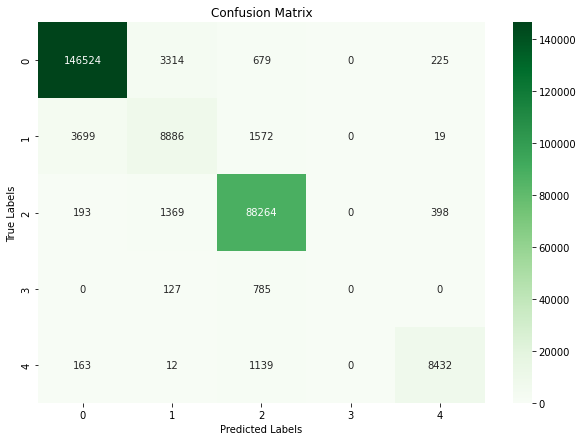

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(y_test_labels, y_pred_labels)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
 

In [16]:
import numpy as np


correct_predictions = np.sum(y_pred_labels == y_test_labels)
total_points = len(y_test_labels)

point_accuracy = correct_predictions / total_points

print(f"Point-by-point accuracy: {point_accuracy * 100:.2f}%")


Point-by-point accuracy: 94.85%


In [23]:
import numpy as np

# checking files inside
file_index = 14  # the number of file from the loaded sequence

# Getting the same file
test_sequence = X_test[file_index]  

# Get the true labels for this sequence
true_classes = np.argmax(y_test[file_index], axis=1)  

# Reshape the sequence (batch_size, sequence_length, features)
test_sequence_reshaped = test_sequence.reshape(1, 300, 1)

# Get the predicted probabilities for each sample in the sequence
predicted_probs = model.predict(test_sequence_reshaped)

# Convert predicted probabilities 
predicted_classes = np.argmax(predicted_probs, axis=2).flatten()  # Shape: (300,)

# Print the predicted classes and true classes
print(f"Predicted classes for file {file_index + 1}: {predicted_classes}")
print(f"True classes for file {file_index + 1}: {true_classes}")

# Check accuracy for this particular sequence
accuracy = np.mean(predicted_classes == true_classes)
print(f"Accuracy for file {file_index + 1}: {accuracy:.4f}")


1/1 [==============================] - 0s 159ms/step
Predicted classes for file 15: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
True classes for file 15: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

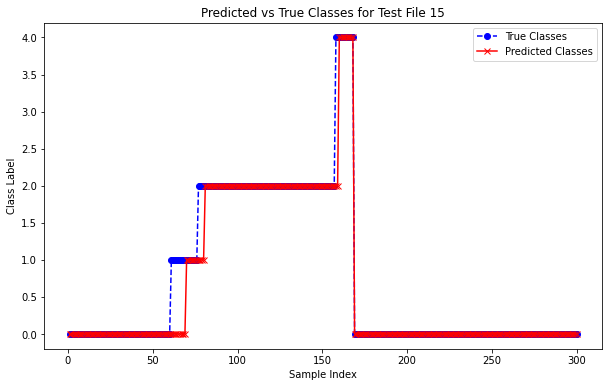

In [24]:
import numpy as np
import matplotlib.pyplot as plt


# Create a plot to visualize the predicted vs true classes
plt.figure(figsize=(10, 6))
plt.plot(range(1, 301), true_classes, label="True Classes", color='blue', linestyle='dashed', marker='o')
plt.plot(range(1, 301), predicted_classes, label="Predicted Classes", color='red', marker='x')

# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.title(f'Predicted vs True Classes for Test File {file_index + 1}')
plt.legend()

# Show the plot
plt.show()


In [25]:
# Loop through each sample in the sequence
for i in range(len(predicted_classes)):
    # Get the predicted class and true class
    predicted_class = predicted_classes[i]
    true_class = true_classes[i]
    
   
    confidence_score = predicted_probs[0, i, predicted_class] * 100  # convert to percentage

    # Print the result with confidence score
    print(f"Sample {i + 1}: Predicted Class = {predicted_class}, True Class = {true_class}, Confidence = {confidence_score:.1f}%")


Sample 1: Predicted Class = 0, True Class = 0, Confidence = 98.9%
Sample 2: Predicted Class = 0, True Class = 0, Confidence = 99.9%
Sample 3: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 4: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 5: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 6: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 7: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 8: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 9: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 10: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 11: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 12: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 13: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 14: Predicted Class = 0, True Class = 0, Confidence = 100.0%
Sample 15: Predicted Class = 0, True Class = 0, Confidence 

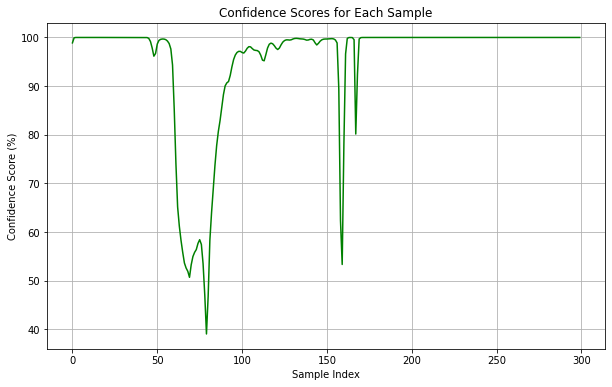

In [26]:
import matplotlib.pyplot as plt

# List to store confidence scores
confidence_scores = []

# Loop through each sample and calculate confidence scores
for i in range(len(predicted_classes)):
    predicted_class = predicted_classes[i]
    confidence_score = predicted_probs[0, i, predicted_class] * 100  
    confidence_scores.append(confidence_score)  # Store the confidence score

# Plotting the confidence scores
plt.figure(figsize=(10, 6))
plt.plot(confidence_scores, linestyle='-', color='g')  # Line plot with markers
plt.title('Confidence Scores for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Confidence Score (%)')
plt.grid(True)

# Show the plot
plt.show()
